# 1. 학습데이터 준비

* Attribute Information:
        1) 알콜(Alcohol)
        2) 말산(Malic acid)
        3) 회분(Ash)
        4) 회분의 알칼리도(Alcalinity of ash)
        5) 마그네슘(Magnesium)
        6) 총 폴리페놀(Total phenols)
        7) 플라보노이드 폴리페놀(Flavanoids)
        8) 비 플라보노이드 폴리페놀(Nonflavanoid phenols)
        9) 프로안토시아닌(Proanthocyanins)
        10) 색상의 강도(Color intensity)
        11) 색상(Hue)
        12) 희석 와인의 OD280/OD315 비율 (OD280/OD315 of diluted wines)
        13) 프롤린(Proline)

In [17]:
from sklearn.datasets import load_wine
datasets = load_wine()

X = datasets.data

y = datasets.target
print(f'input data의 shape은 {X.shape} label data의 shape은 {y.shape}입니다.')

input data의 shape은 (178, 13) label data의 shape은 (178,)입니다.


In [18]:
print(datasets.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [19]:
import pandas as pd

df = pd.DataFrame(datasets.data, columns=datasets.feature_names)
target = pd.Series(datasets.target, dtype="category")
df['class'] = target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [20]:
print(set(y))

{0, 1, 2}


## 1-2. 시각화 해보기

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

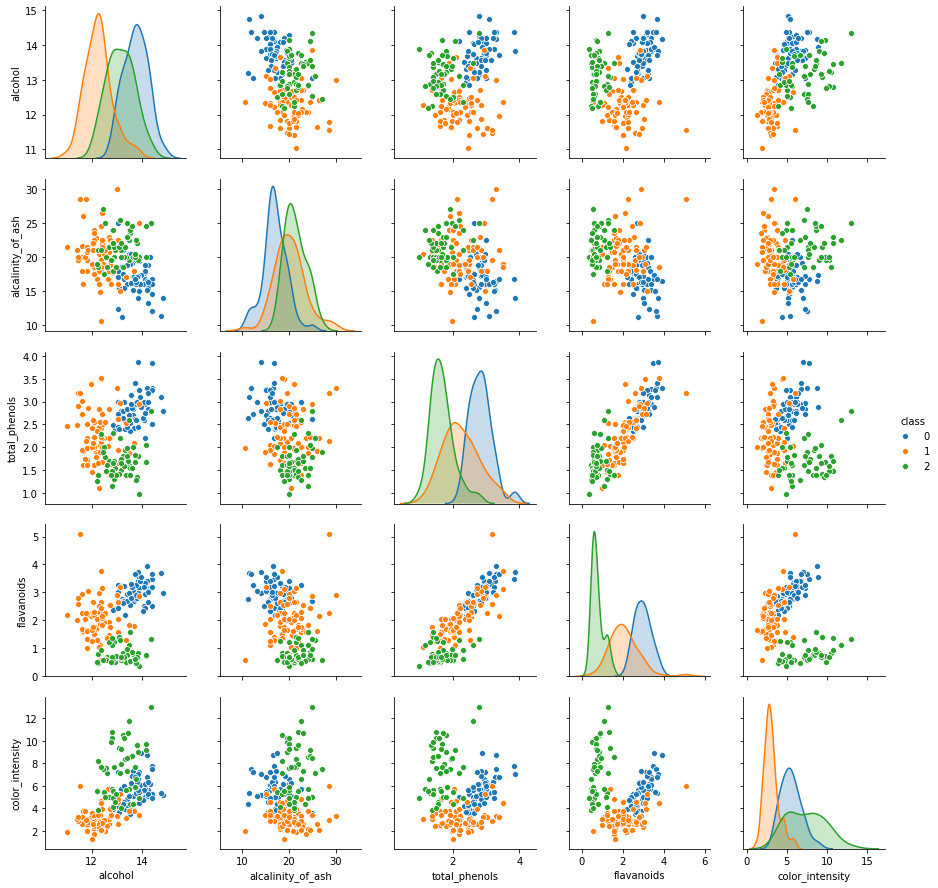

In [22]:
sns.pairplot(vars=["alcohol", "alcalinity_of_ash", "total_phenols", "flavanoids", "color_intensity"], 
             hue="class", data=df)
plt.show()

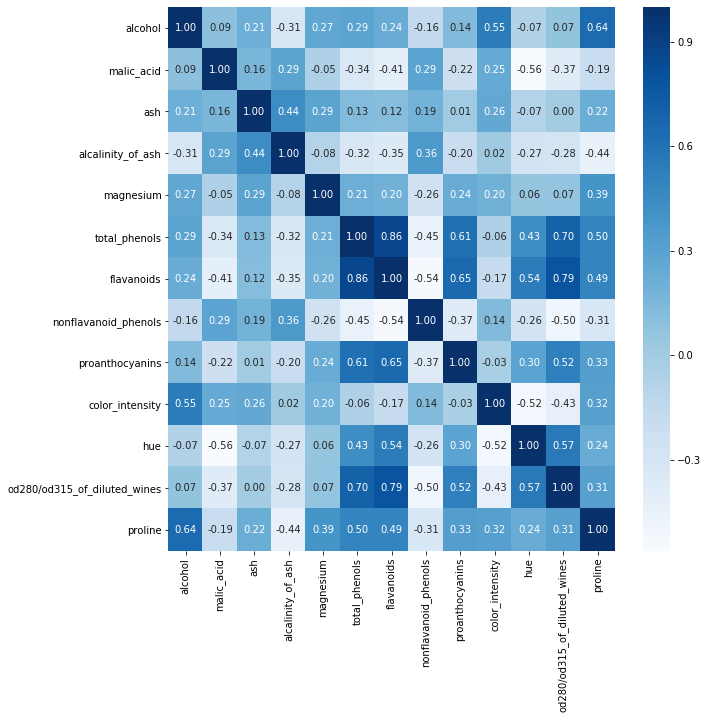

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', cmap='Blues')

## 1-3. 학습, 평가데이터 나누기

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

## 1-4. 정규화  하기

### Z score Normalization:  $\frac{X - \mu}{\sigma}$ 

### min-max Normalization: $\frac{X - X_{min}}{X_{max} - X_{max}}$

In [25]:
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

standardScaler.fit(X_train)

X_scaling_train = standardScaler.transform(X_train)
X_scaling_test = standardScaler.transform(X_test)

## 1-5. 데이터 tensor로 매핑하기

In [26]:
import torch 

X_train_tensor = torch.tensor(X_scaling_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_scaling_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 2 모델 정의 (Logistic Regression)

In [27]:
import torch
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.softmax = nn.Softmax()
    
    def forward(self, X):
        output = self.linear(X)
        output = self.softmax(output)
        return output

model = LogisticRegression(1, 3)

# Loss Function, Optimizer 정의

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# 학습하기

In [32]:
epochs = 5000
total = 0
correct = 0
model.train()
for epoch in range(epochs):
    X_ = X_train_tensor[:,5].unsqueeze(-1)

    prediction = model(X_)
    loss = criterion(prediction, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, predicted = torch.max(prediction.data, 1)
    total += y_train_tensor.size(0)
    correct += (predicted == y_train_tensor).sum().item()
    
    if epoch % 109 == 0:
        print(f'Epoch[{epoch}/{epochs}] Loss:{round(loss.item(), 3)} Acc: {round(100 * correct / total, 3)}')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch[0/5000] Loss:1.097 Acc: 27.731
Epoch[109/5000] Loss:1.095 Acc: 27.731
Epoch[218/5000] Loss:1.093 Acc: 27.731
Epoch[327/5000] Loss:1.092 Acc: 27.731
Epoch[436/5000] Loss:1.091 Acc: 27.731
Epoch[545/5000] Loss:1.089 Acc: 27.731
Epoch[654/5000] Loss:1.088 Acc: 27.731
Epoch[763/5000] Loss:1.086 Acc: 27.731
Epoch[872/5000] Loss:1.085 Acc: 27.763
Epoch[981/5000] Loss:1.083 Acc: 27.856
Epoch[1090/5000] Loss:1.082 Acc: 28.018
Epoch[1199/5000] Loss:1.081 Acc: 28.221
Epoch[1308/5000] Loss:1.079 Acc: 28.441
Epoch[1417/5000] Loss:1.078 Acc: 28.71
Epoch[1526/5000] Loss:1.077 Acc: 28.94
Epoch[1635/5000] Loss:1.075 Acc: 29.166
Epoch[1744/5000] Loss:1.074 Acc: 29.391
Epoch[1853/5000] Loss:1.073 Acc: 29.634
Epoch[1962/5000] Loss:1.071 Acc: 29.884
Epoch[2071/5000] Loss:1.07 Acc: 30.156
Epoch[2180/5000] Loss:1.069 Acc: 30.479
Epoch[2289/5000] Loss:1.068 Acc: 30.788
Epoch[2398/5000] Loss:1.067 Acc: 31.069
Epoch[2507/5000] Loss:1.065 Acc: 31.355
Epoch[2616/5000] Loss:1.064 Acc: 31.677
Epoch[2725/5000

# 테스트하기

In [36]:
epochs = 5000
total = 0
correct = 0
model.eval()

with torch.no_grad():
    
    X_test_ = X_test_tensor[:,5].unsqueeze(-1)

    prediction = model(X_test_)
    _, predicted = torch.max(prediction.data, 1)
    total += y_test_tensor.size(0)
    correct += (predicted == y_test_tensor).sum().item()
    
    print(f'Epoch[{epoch}/{epochs}] Acc: {round(100 * correct / total, 3)}')

Epoch[4999/5000] Acc: 35.593


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
